In [2]:
import numpy as np
import pandas as pd

In [3]:
train_set = pd.read_csv("train.csv", parse_dates=["date"])

train_set["date"] = pd.to_datetime(train_set["date"]) # converting the date column to pandas datetype

In [4]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# unique_dates = pd.date_range(start=train_set["date"].min(), end =train_set["date"].max(), freq="D")
unique_dates = train_set["date"].unique()

# Using DeterministicProcess to generate time dummies (linear and quadratic with order=2) 
# and two Fourier elements for seasonal effects at yearly and weekly frequencies  

fourier1 = CalendarFourier(freq="YE", order=2)  
fourier2 = CalendarFourier(freq="W", order=2)  

train_set_copy = train_set.copy()
train_set_copy.set_index("date")

dp = DeterministicProcess(
    index=unique_dates,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    additional_terms=[fourier1,fourier2],  
    # additional_terms=[fourier1],  
    drop=True,           # drop terms if necessary to avoid collinearity
)

X1 = dp.in_sample()


In [5]:
holidays = pd.read_csv("holidays_events.csv")
holidays = holidays[~holidays["transferred"]]

In [6]:
holiday_dates = holidays["date"]

X1["is_holiday"] = X1.index.isin(holiday_dates).astype(int)

C:\Users\saiha\AppData\Local\Temp\ipykernel_25364\3028887421.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X1["is_holiday"] = X1.index.isin(holiday_dates).astype(int)


In [7]:
compensation_days = holidays["date"][holidays["type"]=="Work Day"]

for date in compensation_days:
    X1.loc[X1.index == pd.to_datetime(date),"is_holiday"] = -1

In [8]:
y1 = train_set.groupby(["date"])['sales'].median()

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X1, y1)

In [10]:
y_pred1 = model.predict(X1)

In [11]:
y_pred1 = pd.Series(y_pred1, index=y1.index)
y_pred1

date
2013-01-01    -1.810673
2013-01-02    -2.917400
2013-01-03    -4.059379
2013-01-04    -1.173465
2013-01-05     0.990140
                ...    
2017-08-11    32.844930
2017-08-12    35.025036
2017-08-13    32.474573
2017-08-14    28.374743
2017-08-15    30.631500
Length: 1684, dtype: float64

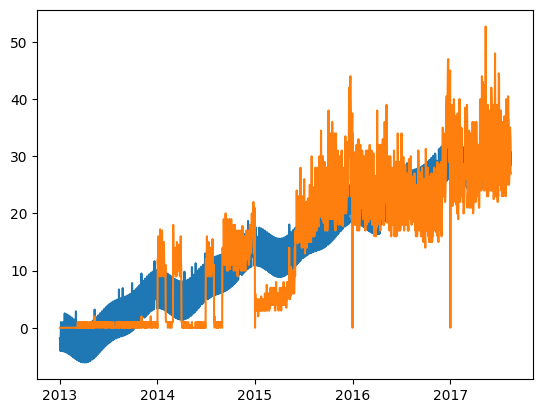

In [12]:
import matplotlib.pyplot as plt

plt.plot(y_pred1)
plt.plot(y1)
# plt.plot(y-y_pred)

In [13]:
# from scipy.signal import periodogram
# frequencies, power = periodogram(y1-y_pred1, fs=1.0)

# periods = {
#     "Yearly": 1/365,
#     "Monthly": 1/30,
#     "Weekly": 1/7,
#     "Daily": 1
# }
# for label, freq in periods.items():
#     plt.axvline(x=freq, color='gray', linestyle='--', alpha=0.5)
#     plt.text(freq, plt.ylim()[1]*0.8, label, rotation=90, color='gray', va='top', ha='center')

# plt.plot(frequencies,power)

In [26]:
y_pred1
sales_set = train_set_copy[["date", "sales"]].set_index("date")
# y_pred1.name = "y_pred1"
y_pred1 = pd.DataFrame(y_pred1)

In [27]:
sales_set = sales_set.merge(y_pred1, on="date", how="left")
sales_set = sales_set.rename(columns={0:"y_pred1"})

In [28]:
sales_set

,sales,y_pred1
date,,
2013-01-01,0.000,-1.810673
2013-01-01,0.000,-1.810673
2013-01-01,0.000,-1.810673
2013-01-01,0.000,-1.810673
2013-01-01,0.000,-1.810673
...,...,...
2017-08-15,438.133,30.631500
2017-08-15,154.553,30.631500
2017-08-15,2419.729,30.631500


In [29]:
y2 = sales_set
y2["sales"] = sales_set["sales"]-sales_set["y_pred1"]
y2 = y2.drop(columns="y_pred1")

In [30]:
y2

,sales
date,
2013-01-01,1.810673
2013-01-01,1.810673
2013-01-01,1.810673
2013-01-01,1.810673
2013-01-01,1.810673
...,...
2017-08-15,407.501500
2017-08-15,123.921500
2017-08-15,2389.097500


In [31]:
X2 = train_set

X2 = X2.reset_index().set_index("date")

In [32]:
X2 = X2.drop(columns=["index","id","sales"])

In [33]:
oil_prices = pd.read_csv("oil.csv")
oil_prices["date"] = pd.to_datetime(oil_prices["date"])
oil_prices = oil_prices.reset_index().set_index("date")
oil_prices = oil_prices.drop(columns="index")

In [34]:
X2 = X2.merge(oil_prices, right_index=True,left_index=True,how="left")

In [35]:
X2

,store_nbr,family,onpromotion,dcoilwtico
date,,,,
2013-01-01,1,AUTOMOTIVE,0,NaN
2013-01-01,1,BABY CARE,0,NaN
2013-01-01,1,BEAUTY,0,NaN
2013-01-01,1,BEVERAGES,0,NaN
2013-01-01,1,BOOKS,0,NaN
...,...,...,...,...
2017-08-15,9,POULTRY,0,47.57
2017-08-15,9,PREPARED FOODS,1,47.57
2017-08-15,9,PRODUCE,148,47.57


In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X2["family"].unique())
X2["family"] = le.transform(X2["family"])

In [76]:
y2

,sales
date,
2013-01-01,1.810673
2013-01-01,1.810673
2013-01-01,1.810673
2013-01-01,1.810673
2013-01-01,1.810673
...,...
2017-08-15,407.501500
2017-08-15,123.921500
2017-08-15,2389.097500


In [81]:
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor


# model2 = XGBRegressor().fit(X2,y2)


model2 = RandomForestRegressor(
    n_estimators=100,     # keep small for test run
    max_depth=10,         # prevent infinite depth
    n_jobs=-1,            # use all cores
    verbose=1             # optional: shows progress
)

model2.fit(X2, y2["sales"])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


RandomForestRegressor(max_depth=10, n_jobs=-1, verbose=1)

In [82]:
y_pred2 = model2.predict(X2)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.4s finished


In [83]:
y_pred = sales_set["y_pred1"] + y_pred2

In [84]:
y_pred

date
2013-01-01     -11.993602
2013-01-01     -18.101138
2013-01-01     -13.226291
2013-01-01     957.383014
2013-01-01     -17.415264
                 ...     
2017-08-15     320.315131
2017-08-15     122.148162
2017-08-15    2785.109335
2017-08-15     131.059317
2017-08-15      16.750169
Name: y_pred1, Length: 3000888, dtype: float64

In [85]:
test_set = pd.read_csv("test.csv", parse_dates=["date"])

test_set["date"] = pd.to_datetime(test_set["date"]) # converting the date column to pandas datetype

In [86]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# unique_dates = pd.date_range(start=train_set["date"].min(), end =train_set["date"].max(), freq="D")
unique_dates = test_set["date"].unique()

# Using DeterministicProcess to generate time dummies (linear and quadratic with order=2) 
# and two Fourier elements for seasonal effects at yearly and weekly frequencies  

fourier1 = CalendarFourier(freq="YE", order=2)  
fourier2 = CalendarFourier(freq="W", order=2)  

# train_set_copy = train_set.copy()
# train_set_copy.set_index("date")

dp = DeterministicProcess(
    index=unique_dates,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    additional_terms=[fourier1,fourier2],  
    # additional_terms=[fourier1],  
    drop=True,           # drop terms if necessary to avoid collinearity
)

X1_test = dp.in_sample()


In [87]:
X1_test["is_holiday"] = X1_test.index.isin(holiday_dates).astype(int)

for date in compensation_days:
    X1_test.loc[X1_test.index == pd.to_datetime(date),"is_holiday"] = -1

C:\Users\saiha\AppData\Local\Temp\ipykernel_25364\3243925231.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X1_test["is_holiday"] = X1_test.index.isin(holiday_dates).astype(int)


In [88]:
y_pred1_test = model.predict(X1_test)

In [89]:
y_pred1_test = pd.DataFrame(y_pred1_test, index = X1_test.index)

In [90]:
y_pred1_test = y_pred1_test.rename(columns={0:"y_pred1_test"})

In [91]:
y_pred1_test

,y_pred1_test
2017-08-16,-5.073359
2017-08-17,-6.202037
2017-08-18,-3.301461
2017-08-19,0.532293
2017-08-20,-2.018432
2017-08-21,-6.118331
2017-08-22,-5.515552
2017-08-23,-4.955894
2017-08-24,-4.429955
2017-08-25,-3.182776


In [92]:
X2_test = test_set

X2_test = X2_test.reset_index().set_index("date")

In [93]:
X2_test = X2_test.merge(oil_prices, right_index=True,left_index=True,how="left")
X2_test = X2_test.drop(columns=["index","id"])

In [94]:
# le = LabelEncoder()
# le.fit(X2_test["family"].unique())
X2_test["family"] = le.transform(X2_test["family"])

In [95]:
X2_test

,store_nbr,family,onpromotion,dcoilwtico
date,,,,
2017-08-16,1,0,0,46.80
2017-08-16,1,1,0,46.80
2017-08-16,1,2,2,46.80
2017-08-16,1,3,20,46.80
2017-08-16,1,4,0,46.80
...,...,...,...,...
2017-08-31,9,28,1,47.26
2017-08-31,9,29,0,47.26
2017-08-31,9,30,1,47.26


In [96]:
y_pred2_test = model2.predict(X2_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [97]:
y_pred2_test

array([ -16.01591325,  -20.6274574 ,  -17.33721895, ..., 1241.75638153,
        104.88382934,  -13.88133073], shape=(28512,))

In [98]:
sales_test = test_set.loc[:,"date"]
sales_test = sales_test.reset_index().set_index("date")

In [99]:
sales_test

,index
date,
2017-08-16,0
2017-08-16,1
2017-08-16,2
2017-08-16,3
2017-08-16,4
...,...
2017-08-31,28507
2017-08-31,28508
2017-08-31,28509


In [100]:
sales_test["y_pred2_test"] = y_pred2_test

In [101]:
sales_test = sales_test.merge(y_pred1_test,how="left",left_index=True,right_index=True)
sales_test

,index,y_pred2_test,y_pred1_test
2017-08-16,0,-16.015913,-5.073359
2017-08-16,1,-20.627457,-5.073359
2017-08-16,2,-17.337219,-5.073359
2017-08-16,3,2227.538067,-5.073359
2017-08-16,4,-20.289310,-5.073359
...,...,...,...
2017-08-31,28507,553.139991,-5.957130
2017-08-31,28508,51.596325,-5.957130
2017-08-31,28509,1241.756382,-5.957130
2017-08-31,28510,104.883829,-5.957130


In [102]:
sales_test

,index,y_pred2_test,y_pred1_test
2017-08-16,0,-16.015913,-5.073359
2017-08-16,1,-20.627457,-5.073359
2017-08-16,2,-17.337219,-5.073359
2017-08-16,3,2227.538067,-5.073359
2017-08-16,4,-20.289310,-5.073359
...,...,...,...
2017-08-31,28507,553.139991,-5.957130
2017-08-31,28508,51.596325,-5.957130
2017-08-31,28509,1241.756382,-5.957130
2017-08-31,28510,104.883829,-5.957130


In [103]:
test_set["id"]

0        3000888
1        3000889
2        3000890
3        3000891
4        3000892
          ...   
28507    3029395
28508    3029396
28509    3029397
28510    3029398
28511    3029399
Name: id, Length: 28512, dtype: int64

In [104]:
test_set.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')

In [105]:
# predictions = sales_test[]
# test_set_ids = test_set.loc[:,"id"]
# test_set_ids.reset_index().set_index(1)

predictions = test_set.drop(columns=["store_nbr","family","onpromotion"])
predictions = predictions.reset_index().set_index("date")
predictions = predictions.drop(columns="index")
predictions

,id
date,
2017-08-16,3000888
2017-08-16,3000889
2017-08-16,3000890
2017-08-16,3000891
2017-08-16,3000892
...,...
2017-08-31,3029395
2017-08-31,3029396
2017-08-31,3029397


In [106]:
predictions["id"].values

array([3000888, 3000889, 3000890, ..., 3029397, 3029398, 3029399],
      shape=(28512,))

In [107]:
predictions= pd.DataFrame({
    "id": predictions["id"].values,
    "sales": sales_test["y_pred1_test"].values + sales_test["y_pred2_test"].values
})

In [108]:
predictions

,id,sales
0,3000888,-21.089272
1,3000889,-25.700816
2,3000890,-22.410578
3,3000891,2222.464709
4,3000892,-25.362668
...,...,...
28507,3029395,547.182861
28508,3029396,45.639196
28509,3029397,1235.799252
28510,3029398,98.926700


In [109]:
predictions.to_csv("predictions_hybridtrial_withoil_RandomForest.csv",index=False)